# 0 - Setting

Load Dependencies

In [0]:
import pandas as pd 
import numpy as np
import datetime
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')
drive.mount('/content/drive',force_remount = True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data_dir = '/content/drive/Shared drives/Predictive Competition/recruit-restaurant-visitor-forecasting/'

# 1 - Reading in the original files

In [0]:
air_visit = pd.read_csv(data_dir + 'air_visit_data.csv')
air_store_info = pd.read_csv(data_dir + 'air_store_info.csv')
hpg_reserve = pd.read_csv(data_dir + 'hpg_reserve.csv')
store_id_relation = pd.read_csv(data_dir + 'store_id_relation.csv')
hpg_store_info = pd.read_csv(data_dir + 'hpg_store_info.csv')
air_reserve = pd.read_csv(data_dir + 'air_reserve.csv')
date_info = pd.read_csv(data_dir + 'date_info.csv')

---
# 2 - Data Preparation

### A. Location data 

The first thing we are doing is splitting restaurants up by city / neighborhood. This will help us see the population and restaurant density in the area and take into account busy vs non busy areas.


We will include the stores that are not in the "air" system initially to help us understand how much traffic each area receives and how much competition our core 150 restaurants have.

However, when feeding into our final training data, we will only include the core 150 stores.

In [0]:
# Making sure that we have included every resturant in both systems for this part
air = pd.merge(air_store_info, store_id_relation, on='air_store_id', how='left')
all_stores = pd.merge(hpg_store_info, air, on = 'hpg_store_id', how='outer')

# Re-ording the columns
# Making sure we have consistent longitude and latitude data
rest_location = all_stores[["air_store_id","hpg_store_id", "latitude_x", "longitude_x", "latitude_y", "longitude_y", "hpg_area_name", "air_area_name","hpg_genre_name","air_genre_name"]]
rest_location.head()

,air_store_id,hpg_store_id,latitude_x,longitude_x,latitude_y,longitude_y,hpg_area_name,air_area_name,hpg_genre_name,air_genre_name
0,NaN,hpg_6622b62385aec8bf,35.643675,139.668221,NaN,NaN,Tōkyō-to Setagaya-ku Taishidō,NaN,Japanese style,NaN
1,NaN,hpg_e9e068dd49c5fa00,35.643675,139.668221,NaN,NaN,Tōkyō-to Setagaya-ku Taishidō,NaN,Japanese style,NaN
2,NaN,hpg_2976f7acb4b3a3bc,35.643675,139.668221,NaN,NaN,Tōkyō-to Setagaya-ku Taishidō,NaN,Japanese style,NaN
3,NaN,hpg_e51a522e098f024c,35.643675,139.668221,NaN,NaN,Tōkyō-to Setagaya-ku Taishidō,NaN,Japanese style,NaN
4,NaN,hpg_e3d0e1519894f275,35.643675,139.668221,NaN,NaN,Tōkyō-to Setagaya-ku Taishidō,NaN,Japanese style,NaN


After merging the data, the longtitude / latitude of the same restarurant appeared twice. This information in two systems are not aligned, so it might be better to check which number is more accurate. 
For now, we take the average value as our final result.

Note that if a value is "null" in one system but present in the other, taking the average automatically omits the null.

In [0]:
rest_location.loc[:,'latitude'] = rest_location.loc[:,['latitude_x', 'latitude_y']].mean(axis=1)
rest_location.loc[:,'longitude'] = rest_location.loc[:,['longitude_x', 'longitude_y']].mean(axis=1)

rest_location.drop(columns=['latitude_x','latitude_y','longitude_x','longitude_y'], inplace=True)
rest_location.head()

,air_store_id,hpg_store_id,hpg_area_name,air_area_name,hpg_genre_name,air_genre_name,latitude,longitude
0,NaN,hpg_6622b62385aec8bf,Tōkyō-to Setagaya-ku Taishidō,NaN,Japanese style,NaN,35.643675,139.668221
1,NaN,hpg_e9e068dd49c5fa00,Tōkyō-to Setagaya-ku Taishidō,NaN,Japanese style,NaN,35.643675,139.668221
2,NaN,hpg_2976f7acb4b3a3bc,Tōkyō-to Setagaya-ku Taishidō,NaN,Japanese style,NaN,35.643675,139.668221
3,NaN,hpg_e51a522e098f024c,Tōkyō-to Setagaya-ku Taishidō,NaN,Japanese style,NaN,35.643675,139.668221
4,NaN,hpg_e3d0e1519894f275,Tōkyō-to Setagaya-ku Taishidō,NaN,Japanese style,NaN,35.643675,139.668221


The location data is provided to us in a single column - we need to split up the column in order to see the city, the neighborhood, and more detailed info. If the store is in our "air" system, we prefer to use the data provided there. If the data is null though, we have to use the data from "hpg".

In [0]:
# Splitting up locations
hpg_df = pd.DataFrame(all_stores["hpg_area_name"].str.split(' ', expand=True))
air_df = pd.DataFrame(all_stores["air_area_name"].str.split(' ', expand=True))

# Naming the columns created from the split
hpg_df.columns = ['hpg_geo1','hpg_geo2','hpg_geo3','hpg_geo4','hpg_geo5']
air_df.columns = ['air_geo1','air_geo2','air_geo3','air_geo4','air_geo5']

# Only keeping relevant info from the split
together = pd.concat([hpg_df, air_df], axis=1)
together = together[['hpg_geo1','hpg_geo2', 'air_geo1','air_geo2']]

# Improved columns representing the city location
together['geo1'] = np.where(together['air_geo1'].isnull(), together['hpg_geo1'], together['air_geo1'])
together['geo2'] = np.where(together['air_geo2'].isnull(), together['hpg_geo2'], together['air_geo2'])

# Removing Japanese characters / symbols
together['geo1'] = together['geo1'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
together['geo2'] = together['geo2'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

together = together[['geo1', 'geo2']]
all_stores = pd.concat([rest_location, together], axis=1)
all_stores.head()

,air_store_id,hpg_store_id,hpg_area_name,air_area_name,hpg_genre_name,air_genre_name,latitude,longitude,geo1,geo2
0,NaN,hpg_6622b62385aec8bf,Tōkyō-to Setagaya-ku Taishidō,NaN,Japanese style,NaN,35.643675,139.668221,Tokyo-to,Setagaya-ku
1,NaN,hpg_e9e068dd49c5fa00,Tōkyō-to Setagaya-ku Taishidō,NaN,Japanese style,NaN,35.643675,139.668221,Tokyo-to,Setagaya-ku
2,NaN,hpg_2976f7acb4b3a3bc,Tōkyō-to Setagaya-ku Taishidō,NaN,Japanese style,NaN,35.643675,139.668221,Tokyo-to,Setagaya-ku
3,NaN,hpg_e51a522e098f024c,Tōkyō-to Setagaya-ku Taishidō,NaN,Japanese style,NaN,35.643675,139.668221,Tokyo-to,Setagaya-ku
4,NaN,hpg_e3d0e1519894f275,Tōkyō-to Setagaya-ku Taishidō,NaN,Japanese style,NaN,35.643675,139.668221,Tokyo-to,Setagaya-ku


To go along with this, we have also added the population for each of the cities. This information comes from [wikipedia](https://en.wikipedia.org/wiki/List_of_cities_in_Japan). We can use the city name to match the corresponding population.

In [0]:
#cities = list(set(all_stores['geo1']))
cities = ['Tokyo-to','Osaka-fu','Fukuoka-ken','Hyogo-ken','Hokkaido','Hiroshima-ken','Shizuoka-ken','Miyagi-ken','Niigata-ken','Osaka','Kanagawa-ken', 'Saitama-ken']
population = [2.7, 1.2, 8.6, 1.1, 1.0, 1.2, 1.5,3.7, 1.5, .8, 2.6, 1.6]
density = [11.9, 5.4, 13.9, 1.3, 1.3, 1.7, .5, 8.5,2.7, .7, 11.9, 4.4]

pop = pd.DataFrame(list(zip(cities, population, density)),
            columns=['cities','population', 'density'])

# Getting rid of Japanese hyphens
first = pd.DataFrame(together["geo1"])
first.columns = ['city']

# Population joining
population = pd.merge(first, pop, left_on = ['city'], right_on= ['cities'], how='left')
population = population.drop(columns = ['cities'])

# Concat the population per city back to original
all_stores = pd.concat([all_stores, population], axis=1)

Now we don't need the latitude and longitude anymore, we already know the mached population, we can drop these columns.

In [0]:
# this is what it should be
all_stores = all_stores.drop(['hpg_area_name','air_area_name','city'],1)

all_stores.head()

,air_store_id,hpg_store_id,hpg_genre_name,air_genre_name,latitude,longitude,geo1,geo2,population,density
0,NaN,hpg_6622b62385aec8bf,Japanese style,NaN,35.643675,139.668221,Tokyo-to,Setagaya-ku,2.7,11.9
1,NaN,hpg_e9e068dd49c5fa00,Japanese style,NaN,35.643675,139.668221,Tokyo-to,Setagaya-ku,2.7,11.9
2,NaN,hpg_2976f7acb4b3a3bc,Japanese style,NaN,35.643675,139.668221,Tokyo-to,Setagaya-ku,2.7,11.9
3,NaN,hpg_e51a522e098f024c,Japanese style,NaN,35.643675,139.668221,Tokyo-to,Setagaya-ku,2.7,11.9
4,NaN,hpg_e3d0e1519894f275,Japanese style,NaN,35.643675,139.668221,Tokyo-to,Setagaya-ku,2.7,11.9


### B. Restaurant types

We are provided with restaurant types for every store in our data, but the labels are not consistent. In order to gain more meaningful data from the types of restaurants we are provided, we convert the many specific labels into more general labels that capture the restaurant type (eg Japanese, Western Food, bars, etc).

In [0]:
# Cleaning up the types of restaurant
# We end up with 5 major types of restaurant + some others
all_stores['Food_Type'] = np.where(all_stores['air_genre_name'].isnull(), 
                                         all_stores['hpg_genre_name'], 
                                         all_stores['air_genre_name'])

all_stores['Food_Type'] = np.where(all_stores['Food_Type'].str.contains(('Izakaya'), case=False, na=False), 'Izakaya',all_stores['Food_Type'])
all_stores['Food_Type'] = np.where(all_stores['Food_Type'].str.contains(("bar"), case=False, na=False), 'Bars', all_stores['Food_Type'])
all_stores['Food_Type'] = np.where(all_stores['Food_Type'].str.contains(("Japanese|Monja|Shabu|Sushi|Udon"), case=False, na=False), 'Japanese', all_stores['Food_Type'])
all_stores['Food_Type'] = np.where(all_stores['Food_Type'].str.contains(('Western|Creative|Karaoke|Other'), case=False, na=False), 'Western/Create', all_stores['Food_Type'])
all_stores['Food_Type'] = np.where(all_stores['Food_Type'].str.contains(("Yakiniku|Korean"), case=False, na=False), 'Korean', all_stores['Food_Type'])
all_stores['Food_Type'] = np.where(all_stores['Food_Type'].str.contains(("Cafe|Sweets"),case=False, na=False), 'Cafe', all_stores['Food_Type'])
all_stores['Food_Type'] = np.where(all_stores['Food_Type'].str.contains(("Italian|French|Spain"), case=False, na=False), 'European', all_stores['Food_Type'])

all_stores['Dining_Cat'] = np.where(all_stores['Food_Type'].str.contains(('Bars|Izakaya'), case=False, na=False), 'Drinks','Food')

### C. Holidays

Also, we think if the next three days is holiday, there might be a higher traffic for restaurant. So we set up a flag to see if the next / previous three days are holiday or not. 
The holiday information is contained in *date_info* table. We can use table as our basis.

In [0]:
date_info = pd.read_csv(data_dir + 'date_info.csv')
# rename the columns to make the column name match other dataset
date_info.rename(columns={'holiday_flg': 'is_holiday', 'calendar_date': 'visit_date'}, inplace=True)

# previous days holiday flag. 1 means holiday, 0 means not
date_info['prev_day'] = date_info['is_holiday'].shift().fillna(0)

# following days holiday flag, 1 means holiday, 0 means not
date_info['next_day'] = date_info['is_holiday'].shift(-1).fillna(0)
date_info.head()

,visit_date,day_of_week,is_holiday,prev_day,next_day
0,2016-01-01,Friday,1,0.0,1.0
1,2016-01-02,Saturday,1,1.0,1.0
2,2016-01-03,Sunday,1,1.0,0.0
3,2016-01-04,Monday,0,1.0,0.0
4,2016-01-05,Tuesday,0,0.0,0.0


If any of the next / previous three days is holiday, we think this is a traffic signal and use 1 to represent, otherwise we use 0.

### D. Create time series features for visit date

Since the data is not complete. We don't have information for the past whole year so that We want to make it complete. We assume that if there the day doesn't appear in our data, there is no visitors on that day. So the `visitors= 0`

In [0]:
air_visit = pd.read_csv(data_dir + 'air_visit_data.csv')

In [0]:
# when setting index, we should conver it to datetime object
#air_visit.index = pd.to_datetime(air_visit['visit_date'])

# aggeregate the visitors per day per store.
# air_visit = air_visit.groupby('air_store_id').apply(lambda g: g['visitors'].resample('1d').sum()).reset_index()

# air_visit['visit_date'] = air_visit['visit_date'].dt.strftime('%Y-%m-%d') # original type is timestamp with hms, now it's %y-m-d

# if the records is not existed before or if its test data
#air_visit['open'] = air_visit['visitors'].apply(lambda x: 1 if x !=0 else 0)
#air_visit.head()

Time Series variables to be created (create based on Datetime column) :
1. quarter, 
2. season (winter, summer), 
3. month, 
4. week, 
5. day of week
6. Days to the 25th of previous month (Japanese people usually get their salary at the 25th of each month)

D1. quarter, D3. month, D4. week, D5. day of week

In [0]:
air_visit["visit_date"] = pd.to_datetime(air_visit["visit_date"])

# 1. quarter, 3. month, 4. week, 5. day of week
air_visit["month"] = air_visit["visit_date"].dt.month
air_visit["week"] = air_visit["visit_date"].dt.week
air_visit["dayofweek"] = air_visit["visit_date"].dt.dayofweek # 0 (sunday) - 6

D2. season
Japan has four distinct seasons: 
March to May is spring; 
June to August is summer; 
September to November is autumn; 
and December to February is winter. 
Each season has very different temperatures and climates

In [0]:
def seasonLabel(row):
    if row['month'] in [3,4,5]:
        return 'spring'
    if row['month'] in [6,7,8]:
        return 'summer'
    if row['month'] in [9,10,11]:
        return 'autumn'
    if row['month'] in [12,1,2]:
        return 'winter'
    
air_visit["season"] = air_visit.apply(lambda row:seasonLabel(row), axis=1)  
    

In [0]:
# 7. Days to the 25th of previous month (Japanese people usually get their salary at the 25th of each month)
# create days to the 25th of previous month
# 7.1 day of month >= 25, day of month - 25
# 7.2 day of month < 25, (days in month - 25) + day of month

air_visit["dayofmonth"] = air_visit["visit_date"].dt.day    
# visit_data["daysinmonth"] = visit_data["visit_date"].dt.daysinmonth 
# visit_data["daysToMonthEnd"] = visit_data["daysinmonth"] - visit_data["dayofmonth"]  
air_visit["daysinPrevmonth"] = (air_visit["visit_date"] - pd.DateOffset(months=1)).dt.daysinmonth 

def daysToPrev25th(row):
    TARGET_DATE = 25
    if row['dayofmonth'] >= 25:
        return row['dayofmonth'] - TARGET_DATE
    else:
        return row['daysinPrevmonth'] - TARGET_DATE + row['dayofmonth']

air_visit["daysToPrev25th"] = air_visit.apply(lambda row:daysToPrev25th(row), axis=1)

In [0]:
air_visit['visit_date'] = air_visit['visit_date'].dt.strftime('%Y-%m-%d') # original type is timestamp with hms, now it's %y-m-d

In [0]:
air_visit.head()

,air_store_id,visit_date,visitors,month,week,dayofweek,season,dayofmonth,daysinPrevmonth,daysToPrev25th
0,air_ba937bf13d40fb24,2016-01-13,25,1,2,2,winter,13,31,19
1,air_ba937bf13d40fb24,2016-01-14,32,1,2,3,winter,14,31,20
2,air_ba937bf13d40fb24,2016-01-15,29,1,2,4,winter,15,31,21
3,air_ba937bf13d40fb24,2016-01-16,22,1,2,5,winter,16,31,22
4,air_ba937bf13d40fb24,2016-01-18,6,1,3,0,winter,18,31,24


# 3 - Final Data generation

Now we have the date information, the area, population, food type ,.etc. We are ready for generating the final training/testing dataset. 

Our test data is implicitly located in the *sample-submission* file. So we can append these files to the original air stores. 
Set up a flag to see if it's test data or not, and we assume all the stores in test period is open. The number of visitors is Null just for now. We will predict these numbers in following training.

In [0]:
# load the test data
submission = pd.read_csv(data_dir + 'sample_submission.csv')
# set a flag to see if this is test data
submission['is_test'] = True
# all test stores should be open in the test period
submission['open'] = 1
# separate the id to store_id and the datte
submission['air_store_id'] = submission['id'].str.slice(0, 20)
submission['visit_date'] = pd.to_datetime(submission['id'].str.slice(21))
# the initial visitor values is null
submission['visitors'] = np.nan

submission['month'] = submission.visit_date.dt.month
submission["week"] = submission["visit_date"].dt.week
submission["season"] = submission.apply(lambda row:seasonLabel(row), axis=1)  

submission["dayofweek"] = submission["visit_date"].dt.dayofweek # 0 (sunday) - 6
submission["dayofmonth"] = submission["visit_date"].dt.day    
submission["daysinPrevmonth"] = (submission["visit_date"] - pd.DateOffset(months=1)).dt.daysinmonth 
submission["daysToPrev25th"] = submission.apply(lambda row:daysToPrev25th(row), axis=1)
submission['visit_date'] = submission['visit_date'].astype(np.str)

# select necessary columns
submission = submission[['air_store_id','visit_date','visitors','is_test','season','daysToPrev25th','week',
                         'month','daysinPrevmonth','dayofweek','dayofmonth']]
submission.head()

,air_store_id,visit_date,visitors,is_test,season,daysToPrev25th,week,month,daysinPrevmonth,dayofweek,dayofmonth
0,air_00a91d42b08b08d9,2017-04-23,NaN,True,spring,29,16,4,31,6,23
1,air_00a91d42b08b08d9,2017-04-24,NaN,True,spring,30,17,4,31,0,24
2,air_00a91d42b08b08d9,2017-04-25,NaN,True,spring,0,17,4,31,1,25
3,air_00a91d42b08b08d9,2017-04-26,NaN,True,spring,1,17,4,31,2,26
4,air_00a91d42b08b08d9,2017-04-27,NaN,True,spring,2,17,4,31,3,27


In [0]:
air_visit['is_test'] = False
air_visit = pd.concat([air_visit, submission],axis = 0)
air_visit['visitors'] = air_visit['visitors'].astype(float)
air_visit['visit_date'] = air_visit['visit_date'].astype(np.str)
air_visit.head()

,air_store_id,dayofmonth,dayofweek,daysToPrev25th,daysinPrevmonth,is_test,month,season,visit_date,visitors,week
0,air_ba937bf13d40fb24,13,2,19,31,False,1,winter,2016-01-13,25.0,2
1,air_ba937bf13d40fb24,14,3,20,31,False,1,winter,2016-01-14,32.0,2
2,air_ba937bf13d40fb24,15,4,21,31,False,1,winter,2016-01-15,29.0,2
3,air_ba937bf13d40fb24,16,5,22,31,False,1,winter,2016-01-16,22.0,2
4,air_ba937bf13d40fb24,18,0,24,31,False,1,winter,2016-01-18,6.0,3


Now we can combine all information together and get our training and test data.

We have each of the 150 restaurants and a corresponding day for every time the store was open.

In [0]:
# all_stores table has all store information.
air_all_date = pd.merge(air_visit, date_info, on = 'visit_date', how = 'left').sort_index()
all_stores = pd.merge(air_all_date,all_stores, on = 'air_store_id', how = 'left')
all_stores.head()

,air_store_id,dayofmonth,dayofweek,daysToPrev25th,daysinPrevmonth,is_test,month,season,visit_date,visitors,week,day_of_week,is_holiday,prev_day,next_day,hpg_store_id,hpg_genre_name,air_genre_name,latitude,longitude,geo1,geo2,population,density,Food_Type,Dining_Cat
0,air_ba937bf13d40fb24,13,2,19,31,False,1,winter,2016-01-13,25.0,2,Wednesday,0,0.0,0.0,NaN,NaN,Dining bar,35.658068,139.751599,Tokyo-to,Minato-ku,2.7,11.9,Bars,Drinks
1,air_ba937bf13d40fb24,14,3,20,31,False,1,winter,2016-01-14,32.0,2,Thursday,0,0.0,0.0,NaN,NaN,Dining bar,35.658068,139.751599,Tokyo-to,Minato-ku,2.7,11.9,Bars,Drinks
2,air_ba937bf13d40fb24,15,4,21,31,False,1,winter,2016-01-15,29.0,2,Friday,0,0.0,0.0,NaN,NaN,Dining bar,35.658068,139.751599,Tokyo-to,Minato-ku,2.7,11.9,Bars,Drinks
3,air_ba937bf13d40fb24,16,5,22,31,False,1,winter,2016-01-16,22.0,2,Saturday,0,0.0,0.0,NaN,NaN,Dining bar,35.658068,139.751599,Tokyo-to,Minato-ku,2.7,11.9,Bars,Drinks
4,air_ba937bf13d40fb24,18,0,24,31,False,1,winter,2016-01-18,6.0,3,Monday,0,0.0,0.0,NaN,NaN,Dining bar,35.658068,139.751599,Tokyo-to,Minato-ku,2.7,11.9,Bars,Drinks


Let's calculate the total reserved visitor numbers for each store for each day. If the reserved records exist both in air and hpg system, we summed two number up. If there the records missing in one system, we will use the values from another system. If we don't have any records in both systems, it will return us NAN. 

In [0]:
final = all_stores[['visit_date','air_store_id', 'geo1', 'population', 'density', 'Food_Type','Dining_Cat', 'day_of_week', 'is_holiday', 'next_day','prev_day','is_test','visitors', 'month', 'season','week', 'daysToPrev25th','latitude','longitude']]
final.head()

,visit_date,air_store_id,geo1,population,density,Food_Type,Dining_Cat,day_of_week,is_holiday,next_day,prev_day,is_test,visitors,month,season,week,daysToPrev25th,latitude,longitude
0,2016-01-13,air_ba937bf13d40fb24,Tokyo-to,2.7,11.9,Bars,Drinks,Wednesday,0,0.0,0.0,False,25.0,1,winter,2,19,35.658068,139.751599
1,2016-01-14,air_ba937bf13d40fb24,Tokyo-to,2.7,11.9,Bars,Drinks,Thursday,0,0.0,0.0,False,32.0,1,winter,2,20,35.658068,139.751599
2,2016-01-15,air_ba937bf13d40fb24,Tokyo-to,2.7,11.9,Bars,Drinks,Friday,0,0.0,0.0,False,29.0,1,winter,2,21,35.658068,139.751599
3,2016-01-16,air_ba937bf13d40fb24,Tokyo-to,2.7,11.9,Bars,Drinks,Saturday,0,0.0,0.0,False,22.0,1,winter,2,22,35.658068,139.751599
4,2016-01-18,air_ba937bf13d40fb24,Tokyo-to,2.7,11.9,Bars,Drinks,Monday,0,0.0,0.0,False,6.0,1,winter,3,24,35.658068,139.751599


In [0]:
# CODE TO MAP PREV YEAR TO CURRENT YEAR
final['visit_date'] = pd.to_datetime(final['visit_date'])
final['prev_visitors'] = final.groupby([final['visit_date'].dt.week, final['visit_date'].dt.weekday])['visitors'].shift()
final.head()

,visit_date,air_store_id,geo1,population,density,Food_Type,Dining_Cat,day_of_week,is_holiday,next_day,prev_day,is_test,visitors,month,season,week,daysToPrev25th,latitude,longitude,prev_visitors
0,2016-01-13,air_ba937bf13d40fb24,Tokyo-to,2.7,11.9,Bars,Drinks,Wednesday,0,0.0,0.0,False,25.0,1,winter,2,19,35.658068,139.751599,NaN
1,2016-01-14,air_ba937bf13d40fb24,Tokyo-to,2.7,11.9,Bars,Drinks,Thursday,0,0.0,0.0,False,32.0,1,winter,2,20,35.658068,139.751599,NaN
2,2016-01-15,air_ba937bf13d40fb24,Tokyo-to,2.7,11.9,Bars,Drinks,Friday,0,0.0,0.0,False,29.0,1,winter,2,21,35.658068,139.751599,NaN
3,2016-01-16,air_ba937bf13d40fb24,Tokyo-to,2.7,11.9,Bars,Drinks,Saturday,0,0.0,0.0,False,22.0,1,winter,2,22,35.658068,139.751599,NaN
4,2016-01-18,air_ba937bf13d40fb24,Tokyo-to,2.7,11.9,Bars,Drinks,Monday,0,0.0,0.0,False,6.0,1,winter,3,24,35.658068,139.751599,NaN


In [0]:
train = final[final.is_test == False].drop('is_test',1)
test = final[final.is_test == True].drop('is_test',1)

In [0]:
train.isna().sum()

visit_date          0
air_store_id        0
geo1                0
population          0
density             0
Food_Type           0
Dining_Cat          0
day_of_week         0
is_holiday          0
next_day            0
prev_day            0
visitors            0
month               0
season              0
week                0
daysToPrev25th      0
latitude            0
longitude           0
prev_visitors     367
dtype: int64

# 4 - Data Cleaning

## Outlier Detection

As we can see, the number of visitors is highly left skewed and the max number reached 877 which seems unreasonable. These values might be outliers. 

We simply define outliers using the following rules:

* Data point that falls outside of 1.5 times of an interquartile range above the 3rd quartile and below the 1st quartile

* Data point that falls outside of 3 standard deviations. 

count    252108.000000
mean         20.973761
std          16.757007
min           1.000000
25%           9.000000
50%          17.000000
75%          29.000000
max         877.000000
Name: visitors, dtype: float64

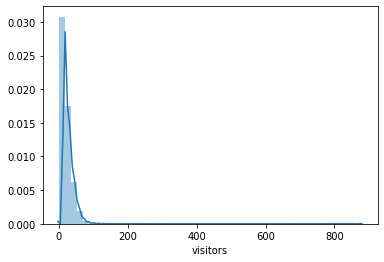

In [0]:
import seaborn as sns
sns.distplot(train.visitors)
train.describe()['visitors']

So we only need to:
*   Arrange the data in increasing order
*   Calculate first(q1) and third quartile(q3)
*   Find interquartile range (q3-q1)
*   Find lower bound q1\*1.5, Find upper bound q3*1.5



In [0]:
train = train.sort_values(by = 'visitors')
#q1, q3= np.percentile(train.visitors,[25,75])
#iqr = q3 - q1
#lower_bound = q1 -(2 * iqr) 
#upper_bound = q3 +(2 * iqr)
#print('The lower bound of visitors is {:.2f}'.format(lower_bound))
#print('The upper bound of visitors is {:.2f}'.format(upper_bound))

The lower bound of visitors is -31.00
The upper bound of visitors is 69.00


The min number of visitors should be 0 under the context. So we don't need to deal with values that are less than 0. And we use the upper bound value to substitude the outliers rather than remove them.

In [0]:
# len(train.loc[train.visitors > 300 ,'visitors'])

16

In [0]:
  train.loc[train.visitors > upper_bound ,'visitors'] = -1
  train = train[train['visitors'] >= 0]

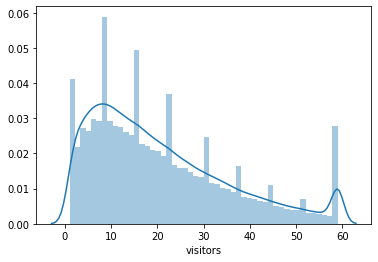

In [0]:
sns.distplot(train.visitors)

In [0]:
train

,visit_date,air_store_id,geo1,population,density,Food_Type,Dining_Cat,day_of_week,is_holiday,next_day,prev_day,visitors,month,season,week,daysToPrev25th,latitude,longitude,prev_visitors
51576,2016-02-08,air_1f7f8fa557bc0d55,Osaka-fu,1.2,5.4,Bars,Drinks,Monday,0,0.0,0.0,1.0,2,winter,6,14,34.766093,135.628100,3.0
88861,2016-08-01,air_caf996ac27206301,Tokyo-to,2.7,11.9,Bars,Drinks,Monday,0,0.0,0.0,1.0,8,summer,31,7,35.735623,139.651658,50.0
248439,2016-01-29,air_bfafaed35e213fd7,Tokyo-to,2.7,11.9,European,Food,Friday,0,0.0,0.0,1.0,1,winter,4,4,35.629564,139.684992,8.0
130124,2016-09-14,air_95e917913cd988f3,Osaka-fu,1.2,5.4,Cafe,Food,Wednesday,0,0.0,0.0,1.0,9,autumn,37,20,34.681261,135.509801,16.0
123643,2017-01-24,air_a21ffca0bea1661a,Tokyo-to,2.7,11.9,Bars,Drinks,Tuesday,0,0.0,0.0,1.0,1,winter,4,30,35.693840,139.703549,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143894,2016-01-24,air_43d577e0c9460e64,Hyogo-ken,1.1,1.3,Western/Create,Food,Sunday,0,0.0,0.0,59.0,1,winter,3,30,34.737597,135.341564,18.0
172123,2016-08-30,air_eca5e0064dc9314a,Fukuoka-ken,8.6,13.9,Cafe,Food,Tuesday,0,0.0,0.0,59.0,8,summer,35,5,33.589216,130.392813,17.0
72836,2016-07-10,air_f2985de32bb792e0,Tokyo-to,2.7,11.9,Izakaya,Drinks,Sunday,0,0.0,0.0,59.0,7,summer,27,15,35.561257,139.716051,22.0
214825,2017-04-18,air_8c3175aa5e4fc569,Tokyo-to,2.7,11.9,Bars,Drinks,Tuesday,0,0.0,0.0,59.0,4,spring,16,24,35.732286,139.710247,27.0


In [0]:
# # write the table
# train.to_csv('/content/drive/Shared drives/Predictive Competition/recruit-restaurant-visitor-forecasting/final_train.csv')
# test.to_csv('/content/drive/Shared drives/Predictive Competition/recruit-restaurant-visitor-forecasting/final_test.csv')

## Merge the final train and test table

In [0]:
train_ni = pd.read_csv(data_dir + 'train_Nina.csv',parse_dates=['visit_date'])

In [0]:
test_ni = pd.read_csv(data_dir + 'test_Nina.csv',parse_dates=['visit_date'])

In [0]:
train_final = pd.merge(train,train_ni, on = ['air_store_id','visit_date'],how='left')

In [0]:
test_final = pd.merge(test,test_ni, on = ['air_store_id','visit_date'],how='left')

In [0]:
train_final['Dining_yes'] = np.where(train_final['Dining_Cat'] == 'Food', 1, 0)
test_final['Dining_yes'] = np.where(test_final['Dining_Cat'] == 'Food', 1, 0)

In [0]:
train_final.isna().sum()

train_final = train_final[['visit_date', 'air_store_id', 'geo1','population','density', 'Food_Type','is_holiday', 
                           'next_day', 'prev_day', 'visitors_x','season', 'week', 'daysToPrev25th',
                           'prev_visitors','year', 'month_y','Dining_yes',
                           'day', 'min_visitors', 'mean_visitors', 'median_visitors',
                           'max_visitors', 'count_observations', 'reserve_visitors', 'days_diff',
                           'latitude_y', 'longitude_y', 'day_of_week_y', 'Consecutive_holidays']]

In [0]:
train_final.head()

,visit_date,air_store_id,geo1,population,density,Food_Type,is_holiday,next_day,prev_day,visitors_x,season,week,daysToPrev25th,prev_visitors,year,month_y,Dining_yes,day,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,reserve_visitors,days_diff,latitude_y,longitude_y,day_of_week_y,Consecutive_holidays
0,2016-01-13,air_ba937bf13d40fb24,Tokyo-to,2.7,11.9,Bars,0,0.0,0.0,25.0,winter,2,19,NaN,2016,1,0,13,7,23.843750,25.0,57,64,-1.0,-1.0,35.658068,139.751599,Wednesday,0.0
1,2016-01-14,air_ba937bf13d40fb24,Tokyo-to,2.7,11.9,Bars,0,0.0,0.0,32.0,winter,2,20,NaN,2016,1,0,14,2,20.292308,21.0,54,65,-1.0,-1.0,35.658068,139.751599,Thursday,0.0
2,2016-01-15,air_ba937bf13d40fb24,Tokyo-to,2.7,11.9,Bars,0,0.0,0.0,29.0,winter,2,21,NaN,2016,1,0,15,4,34.738462,35.0,61,65,-1.0,-1.0,35.658068,139.751599,Friday,0.0
3,2016-01-16,air_ba937bf13d40fb24,Tokyo-to,2.7,11.9,Bars,0,0.0,0.0,22.0,winter,2,22,NaN,2016,1,0,16,6,27.651515,27.0,53,66,-1.0,-1.0,35.658068,139.751599,Saturday,0.0
4,2016-01-18,air_ba937bf13d40fb24,Tokyo-to,2.7,11.9,Bars,0,0.0,0.0,6.0,winter,3,24,NaN,2016,1,0,18,2,13.754386,12.0,34,57,-1.0,-1.0,35.658068,139.751599,Monday,0.0


In [0]:
train_final.to_csv('/content/drive/Shared drives/Predictive Competition/recruit-restaurant-visitor-forecasting/train_final.csv')

In [0]:
#test_final.head()

In [0]:
test_final.columns

Index(['visit_date', 'air_store_id', 'geo1', 'population', 'density',
       'Food_Type', 'Dining_Cat', 'day_of_week_x', 'is_holiday', 'next_day',
       'prev_day', 'visitors', 'month_x', 'season', 'week', 'daysToPrev25th',
       'latitude_x', 'longitude_x', 'prev_visitors', 'year', 'month_y', 'day',
       'min_visitors', 'mean_visitors', 'median_visitors', 'max_visitors',
       'count_observations', 'reserve_visitors', 'days_diff', 'day_of_week_y',
       'holiday_flg', 'Consecutive_holidays', 'air_genre_name',
       'air_area_name', 'latitude_y', 'longitude_y', 'Dining_yes'],
      dtype='object')

In [0]:
test_final = test_final[['visit_date', 'air_store_id', 'geo1','density','population','Food_Type','is_holiday', 
                           'next_day', 'prev_day','season', 'Dining_yes','week', 'daysToPrev25th',
                           'prev_visitors','year', 'month_y',
                           'day', 'min_visitors', 'mean_visitors', 'median_visitors',
                           'max_visitors', 'count_observations', 'reserve_visitors', 'days_diff',
                           'latitude_y', 'longitude_y', 'day_of_week_y', 'Consecutive_holidays']]


In [0]:
test_final.head()

,visit_date,air_store_id,geo1,density,population,Food_Type,is_holiday,next_day,prev_day,season,Dining_yes,week,daysToPrev25th,prev_visitors,year,month_y,day,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,reserve_visitors,days_diff,latitude_y,longitude_y,day_of_week_y,Consecutive_holidays
0,2017-04-23,air_00a91d42b08b08d9,Tokyo-to,11.9,2.7,European,0,0.0,0.0,spring,1,16,29,7.0,2017,4,23,2.0,2.000000,2.0,2.0,1.0,-1.0,-1.0,35.694003,139.753595,Sunday,0.0
1,2017-04-24,air_00a91d42b08b08d9,Tokyo-to,11.9,2.7,European,0,0.0,0.0,spring,1,17,30,2.0,2017,4,24,1.0,22.457143,19.0,47.0,35.0,-1.0,-1.0,35.694003,139.753595,Monday,0.0
2,2017-04-25,air_00a91d42b08b08d9,Tokyo-to,11.9,2.7,European,0,0.0,0.0,spring,1,17,0,2.0,2017,4,25,1.0,24.350000,24.5,43.0,40.0,-1.0,-1.0,35.694003,139.753595,Tuesday,0.0
3,2017-04-26,air_00a91d42b08b08d9,Tokyo-to,11.9,2.7,European,0,0.0,0.0,spring,1,17,1,9.0,2017,4,26,15.0,28.125000,28.0,52.0,40.0,-1.0,-1.0,35.694003,139.753595,Wednesday,0.0
4,2017-04-27,air_00a91d42b08b08d9,Tokyo-to,11.9,2.7,European,0,0.0,0.0,spring,1,17,2,22.0,2017,4,27,15.0,29.868421,30.0,47.0,38.0,-1.0,-1.0,35.694003,139.753595,Thursday,0.0


In [0]:
len(test_final.columns)

28

In [0]:
len(train_final.columns)

29

In [0]:
test_final.to_csv('/content/drive/Shared drives/Predictive Competition/recruit-restaurant-visitor-forecasting/test_final.csv')